# TUTORIAL 2 : Optimize the optical design of a CASSI

## Introduction


This notebook demonstrates how to optimize and test a CASSI system using the provided functions. The process involves loading configurations, running the optimization, and then testing the system with the optimized parameters.

## 1. Initialization
### Importing Necessary Libraries

In [1]:
import os
import json
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import yaml
from pprint import pprint
from torch.optim import Adam


from simca import load_yaml_config
from simca.CassiSystem import CassiSystemOptim
from simca.cost_functions_optics import (
    evaluate_spectral_dispersion_values,
    evaluate_distance,
    get_cassi_system_no_spectial_distorsions,
    initialize_optimizer,
    setup_results_directory,
    plot_glass_selection,
    evaluate_cost_functions,
    format_score_details,
    save_optimization_details,
    get_catalog_glass_infos,
    evaluate_optical_performances,
    plot_grids_coordinates
)
from simca.functions_optim import save_config_system
from opticalglass.glassfactory import get_glass_catalog


# Set autoreload to automatically reload all modules before executing code
%load_ext autoreload
%autoreload 2

In [2]:
def optimize_cassi_system(params_to_optimize,target_dispersion, cost_weights, config_path, iterations, patience, results_dir,device='cpu'):
    config_system = load_yaml_config(config_path)
    cassi_system = CassiSystemOptim(system_config=config_system,device=device)
    device = cassi_system.device
    catalog = config_system["system architecture"]["dispersive element"]["catalog"]

    list_of_glasses, nd_values, vd_values = get_catalog_glass_infos(catalog=catalog, device=device)

    optimizer = initialize_optimizer(cassi_system,params_to_optimize)
    non_improvement_count = 0
    best_loss = float('inf')

    optimization_details = []

    for i in range(iterations):
        optimizer.zero_grad()

        if cassi_system.system_config['system architecture']['dispersive element']['type'] == 'amici':
            cassi_system.optical_model.A3 = cassi_system.optical_model.A1
            cassi_system.optical_model.nd3 = cassi_system.optical_model.nd1
            cassi_system.optical_model.vd3 = cassi_system.optical_model.vd1

        score, cost_details, weighted_cost_components,interesting_values = evaluate_cost_functions(cassi_system, cost_weights, target_dispersion, nd_values, vd_values, i, list_of_glasses)
        current_loss = score.item()

        latest_optical_params = {param_name: param.clone().detach() for param_name, param in cassi_system.optical_model.named_parameters()}



        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {current_loss}')


            details = {
                'reason_for_stopping': 'no improvement' if non_improvement_count >= patience else 'completed',
                'iterations': i,
                'end_parameters': {
                    param_name: (param.item() if 'A' not in param_name and 'alpha_c' not in param_name and 'delta' not in param_name else math.degrees(param.item()))
                    for param_name, param in latest_optical_params.items()
                },
                'optical system values': {param_name: (param.item() if 'deviation' not in param_name else math.degrees(param.item())) for param_name, param in interesting_values.items()},
                'current_loss': current_loss,
            }
            optimization_details.append(details)

            # Save optical characteristics corresponding to the various iterations
            details_path = os.path.join(results_dir, 'optimization_details.json')
            with open(details_path, 'w') as f:
                json.dump(optimization_details, f, indent=4)

            score_details = format_score_details(cost_details,weighted_cost_components,cost_weights)
            # Save the cost functions score details
            details_path = os.path.join(results_dir, f'score_details_iteration_{i}.json')
            with open(details_path, 'a') as f:
                json.dump(score_details, f, indent=4)

        if math.isnan(current_loss):
            print("nan value")
            break

        score.backward()
        optimizer.step()

        if current_loss < best_loss:
            best_loss = current_loss
            non_improvement_count = 0
        else:
            non_improvement_count += 1

        if non_improvement_count >= patience:
            print(f'Stopping early at iteration {i} due to no improvement.')
            break

In [3]:
def test_cassi_system(config_path,device):

    config_system = load_yaml_config(config_path)
    cassi_system = CassiSystemOptim(system_config=config_system,device=device)

    plot_grids_coordinates(cassi_system)
    performances = evaluate_optical_performances(cassi_system)

    return cassi_system.system_config, performances



In [4]:
# A ajouter dans la DOC
#  --- c'est l'ouverture codée qui limite le champ de vue
# --- expliquer comment ajouter une fonction de coût ?
# --- faire en sorte que le le A1=A2=A3=0 fonctionne + A2=A3=0 equivalent à simple prism
# in score_details, seperate between cost_functions vanilla, cost_functions_weighted, and weights

target_dispersion = 1000 # in [µm] ---> modify to spectral spreading

params_to_optimize = [
    'lba_c',
    'alpha_c',
    'A1',
    'A2',
    'nd1',
    'nd2',
    'vd1',
    'vd2'
]

cost_weights = {
    'cost_dispersion': 1.0,
    'cost_distance_glasses': 1.0,
    'cost_deviation': 1.0,
    'cost_distorsion': 1.0,
    'cost_thickness': 1.0,
    'cost_beam_compression': 1.0,
    'cost_non_linearity': 1.0,
    'cost_distance_total_intern_reflection': 1.0
}
init_config_path = "simca/configs/cassi_system_optim_optics_amici_optica.yml"

iterations = 15000
patience = 2000
device= "cuda"

results_dir = setup_results_directory()

# Optimization
optimize_cassi_system(params_to_optimize,target_dispersion, cost_weights, init_config_path, iterations, patience, results_dir,device=device)



/home/arouxel/Documents/these/simca/simca/OpticalModelTorch.py:201: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  k = torch.matmul(k,rotation_y(angle_with_P2).T)


Iteration 0, Loss: 1304390.875
Iteration 100, Loss: 410322.5625
Iteration 200, Loss: 175221.375
Iteration 300, Loss: 121668.125
Iteration 400, Loss: 104636.96875
Iteration 500, Loss: 92851.0703125
Iteration 600, Loss: 82911.2578125
Iteration 700, Loss: 74439.140625
Iteration 800, Loss: 67786.546875
Iteration 900, Loss: 61811.7421875
Iteration 1000, Loss: 56317.828125
Iteration 1100, Loss: 51376.1484375
Iteration 1200, Loss: 46971.68359375
Iteration 1300, Loss: 43135.2734375
Iteration 1400, Loss: 39758.625
Iteration 1500, Loss: 36857.47265625
Iteration 1600, Loss: 34309.61328125
Iteration 1700, Loss: 32106.802734375
Iteration 1800, Loss: 30184.513671875
Iteration 1900, Loss: 28522.990234375
Iteration 2000, Loss: 27085.4921875
Iteration 2100, Loss: 25876.244140625
Iteration 2200, Loss: 24854.0625
Iteration 2300, Loss: 23968.01953125
Iteration 2400, Loss: 23254.3671875
Iteration 2500, Loss: 22680.552734375
Iteration 2600, Loss: 22227.90234375
Iteration 2700, Loss: 21846.54296875
Iteration

In [5]:
output_config_path = "simca/configs/test.yml"
save_config_system(output_config_path,results_dir,init_config_path,iteration_nb=300)


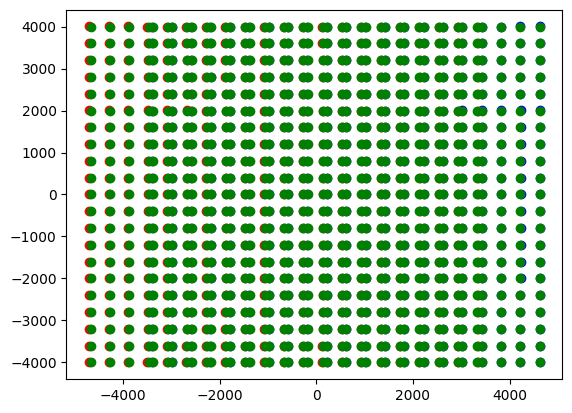

In [6]:
# Testing (retrieve the last iteration data by default)
config_system, performances = test_cassi_system(output_config_path,device=device)

In [7]:
print("\n---- Optical System Configuration----")
pprint(config_system)


---- Optical System Configuration----
{'coded aperture': {'number of pixels along X': 21,
                    'number of pixels along Y': 21,
                    'pixel size along X': 400,
                    'pixel size along Y': 400},
 'detector': {'number of pixels along X': 112,
              'number of pixels along Y': 112,
              'pixel size along X': 71,
              'pixel size along Y': 71},
 'infos': {'system name': 'HYACAMEO'},
 'spectral range': {'number of spectral samples': 10,
                    'wavelength max': 650,
                    'wavelength min': 450},
 'system architecture': {'dispersive element': {'A1': 31.08834708283798,
                                                'A2': 48.23402752234842,
                                                'A3': 31.08834708283798,
                                                'alpha_c': 1.7665617277576846,
                                                'catalog': 'Schott',
                                        

In [8]:

print("\n---- Optical Performances ----")
pprint(performances)


---- Optical Performances ----
{'beam_compression [no units]': 0.5585954785346985,
 'deviation [deg]': 0.00933307409286499,
 'dispersion [um]': 1289,
 'max distortion [um]': 32.85225296020508,
 'mean distortion [um]': 7.694333076477051}
